In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
def read_out_tr(dir, file):
    col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
    df = pd.read_csv(dir+file, sep = ' ', header = None)
    df.columns = col
    return df

# Monitoring queue length by Mengqi
def get_src_packets(df, switch):
    # get all the tcp pkts (Modified by Peixuan)
    #df = df[["time","events", "pkt_type", "from_node", "to_node"]]
    df = df.loc[df["events"].isin(["+", "-", "d"])]
    df = df.loc[df["pkt_type"].isin(["tcp"])]
    df = df.loc[df["from_node"].isin([switch])]
    return df

def sort_by_time(df):    
    df = df.sort_values(by=["time", "events"])
    return df

def plot(df, df2):
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(111)
    ax1.plot(df["time"], df["queue_len"])
    ax1.plot(df["time"], df["queue_drop"])
    ax1.set_ylabel('Queue Length')
    ax1.set_xlabel('Time')
    ax1.set_title("Queue length and queuing delay")
    ax1.legend()
    
    ax2 = ax1.twinx()
    ax2.plot(df2,'g')
    ax2.set_ylabel('Queuing delay')
    
    plt.show()
    
def cal_queue_len(df_out_tr, switch):
    df_queue = get_src_packets(df_out_tr, switch)
    # queuing delay
    df_out=df_queue.groupby('pkt_id')
    delay = df_out.last()['time']-df_out.first()['time']
    x = df_out.last()['time']
    frame = {"time":x, "delay":delay}
    df_delay = pd.DataFrame(frame) 
    df_delay = df_delay.groupby('time').max()
    df_delay = df_delay.sort_values(by=["time"])
    # queue len & drop
    df_queue = sort_by_time(df_queue)
    pktCount = 0
    queue_len = []
    pktDrop = 0
    queue_drop = []
    for index, row in df_queue.iterrows():
        if row["events"] == 'd': 
            pktDrop +=1
            pktCount -= 1
        if row["events"] == '-':
            pktCount -= 1
        if row["events"] == '+':
            pktCount += 1
        queue_len.append(pktCount)
        queue_drop.append(pktDrop)
    df_queue["queue_len"] = queue_len
    df_queue["queue_drop"] = queue_drop
    plot(df_queue, df_delay)
    
def plot_flow_path_queue_length(df, fid):
    df_out = df.loc[df["pkt_type"].isin(["tcp"])]
    df_out = df_out.loc[df_out["fid"].isin([fid])]
    print("from", df_out.from_node.unique())
    print("to", df_out.to_node.unique())
    for switch in df_out.from_node.unique():
        cal_queue_len(df, switch)
        

In [3]:
if __name__ == '__main__':
    df_out_tr_6 = read_out_tr("/home/pg_ga/lining/Gearbox/automatic/BDP/", \
                                  "DropTail_flow_200_0.8_Topology-incast-singlenode-large-number-8.tcl_out.tr")

from [35 13  0  8  6 19]
to [13  0  8  6 19 83]


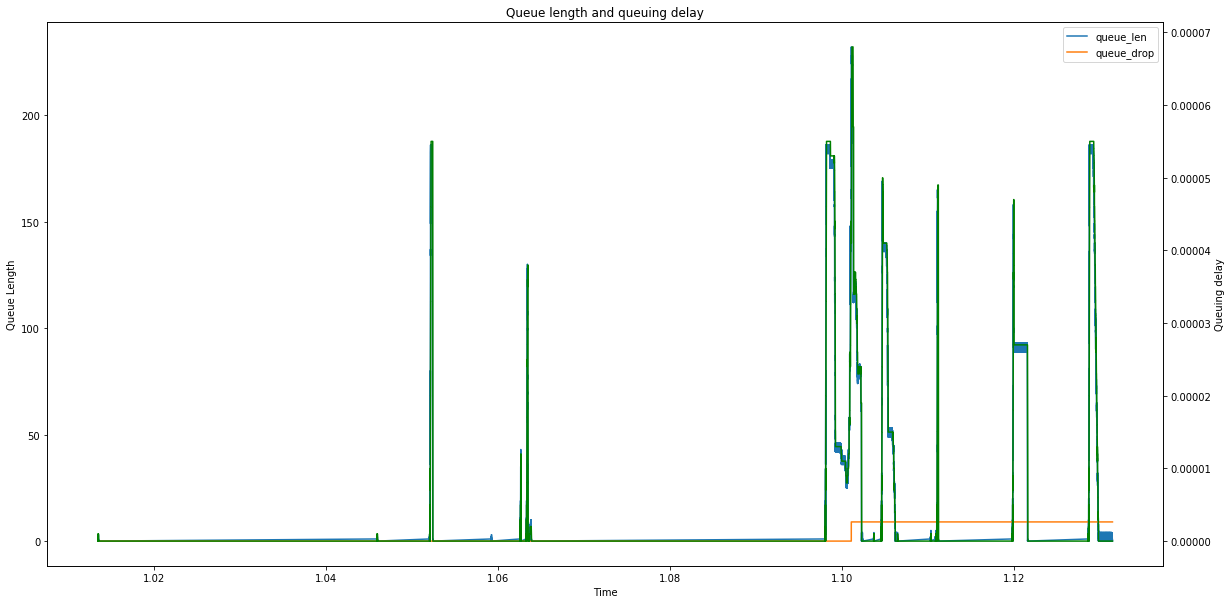

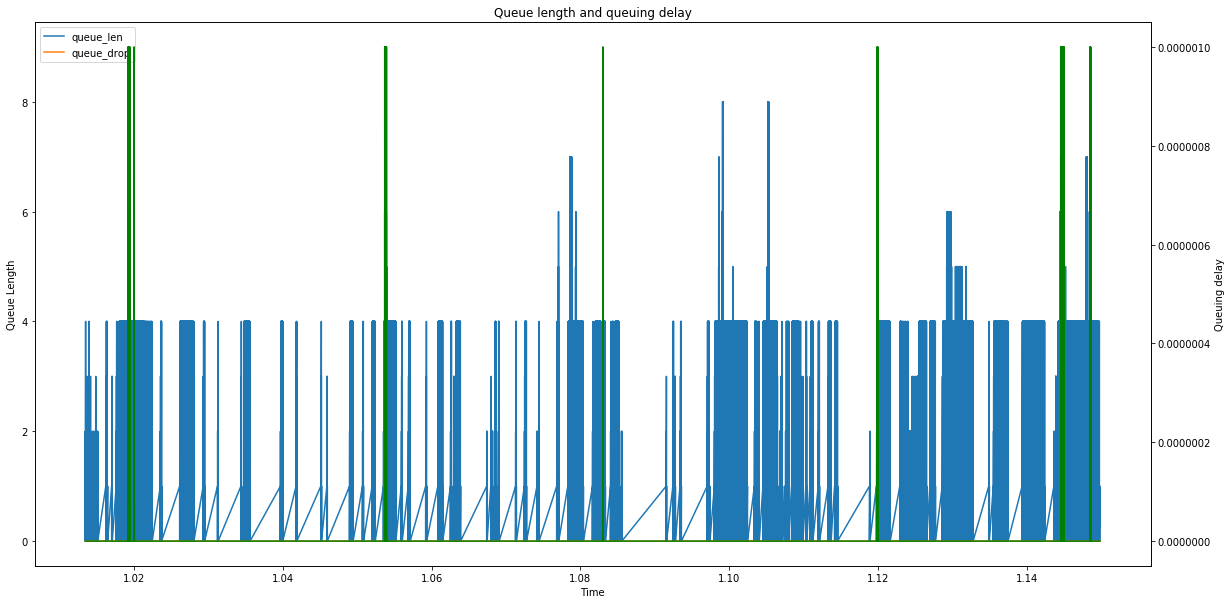

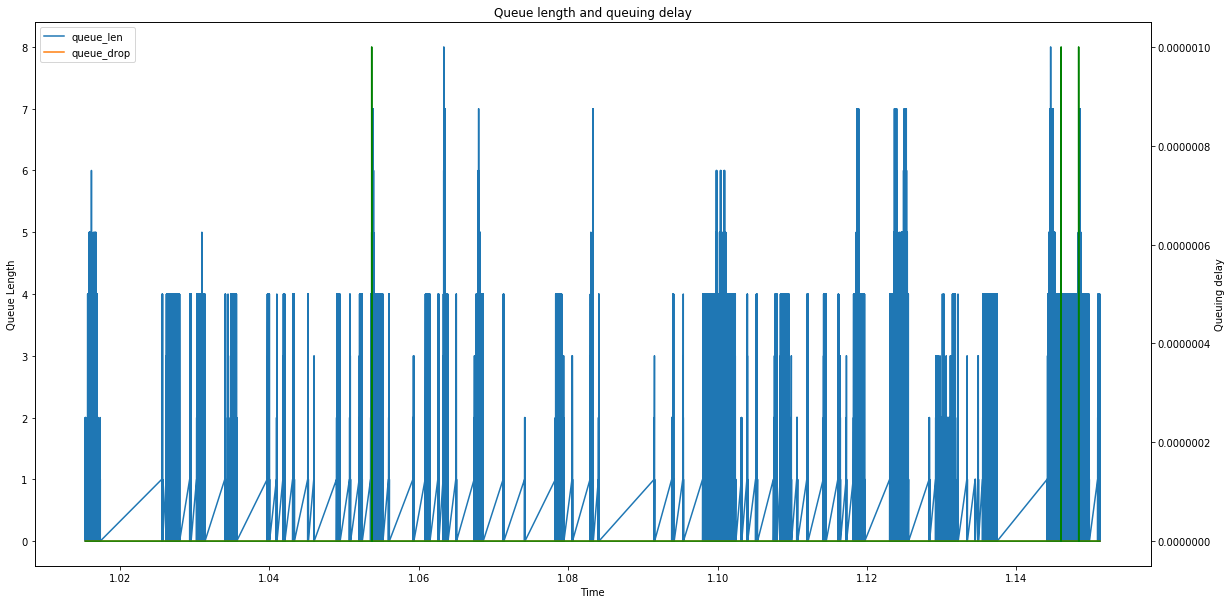

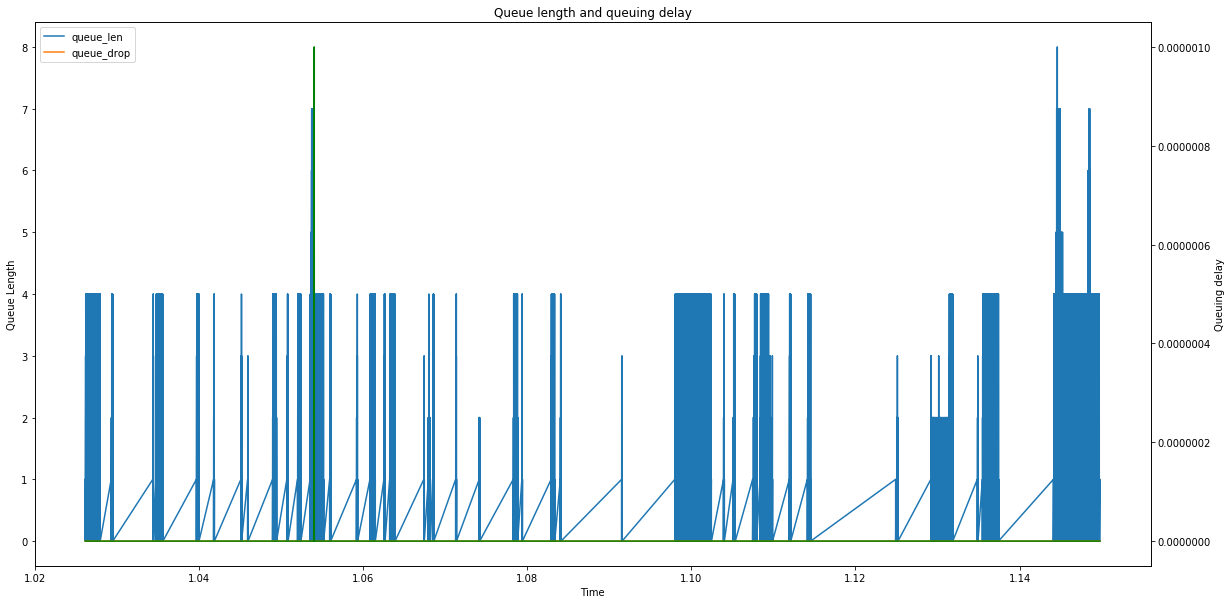

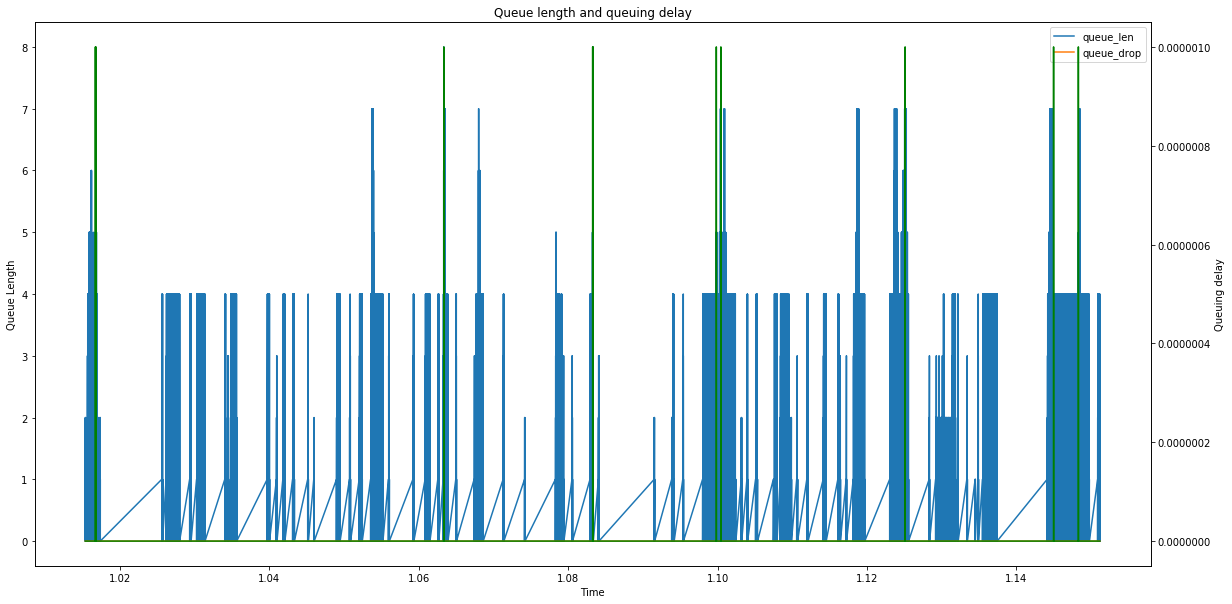

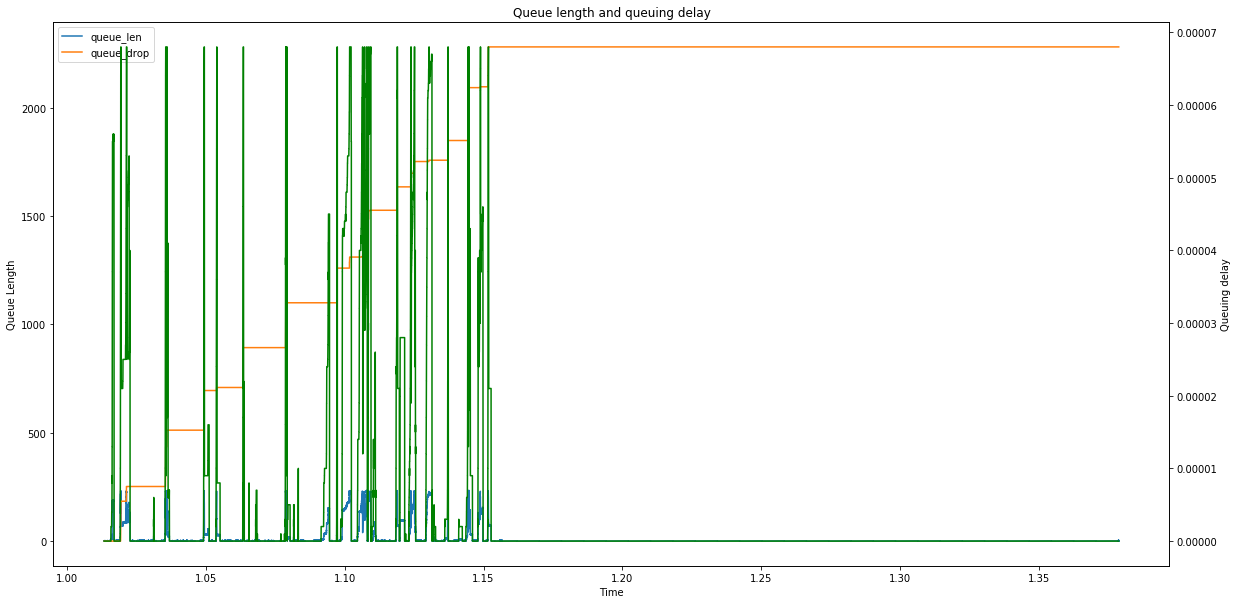

In [4]:
if __name__ == '__main__':
    plot_flow_path_queue_length(df_out_tr_6, 180)
    df = df_out_tr_6
    df_out = df.loc[df["pkt_type"].isin(["tcp"])]
    
    df_queue = get_src_packets(df_out, 19) # switch
    df_out=df_queue.groupby('pkt_id')